![](images/SSD.jpg)

In [1]:
import torch
from d2l import torch as d2l
import torchvision
from torch import nn
from torch.nn import functional as F

设目标类别的数量为q。这样一来，锚框有q+1个类别，其中0类是背景。 在某个尺度下，设特征图的高和宽分别为h和w。 如果以其中每个单元为中心生成a个锚框，那么我们需要对hwa个锚框进行分类。 如果使用全连接层作为输出，很容易导致模型参数过多。
具体来说，类别预测层使用一个保持输入高和宽的卷积层。 这样一来，输出和输入在特征图宽和高上的空间坐标一一对应。 考虑输出和输入同一空间坐标（x、y）：输出特征图上（x、y）坐标的通道里包含了以输入特征图（x、y）坐标为中心生成的所有锚框的类别预测。 因此输出通道数为a(q+1)，其中索引为i（q+1）+j的通道代表了索引为i的锚框有关类别索引为j的预测。

In [2]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1), kernel_size=3, padding=1) # 输出高宽不变

边界框预测层的设计与类别预测层的设计类似。 唯一不同的是，这里需要为每个锚框预测4个偏移量，而不是q+1个类别。

In [3]:
def bbox_predictor(num_inputs, num_anchors):
    return nn.Conv2d(num_inputs, num_anchors * 4, kernel_size=3, padding=1)

In [4]:
def forward(x, block):
    return block(x)

Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

正如我们所看到的，除了批量大小这一维度外，其他三个维度都具有不同的尺寸。 为了将这两个预测输出链接起来以提高计算效率，我们将把这些张量转换为更一致的格式。
通道维包含中心相同的锚框的预测结果。我们首先将通道维移到最后一维。 因为不同尺度下批量大小仍保持不变，我们可以将预测结果转成二维的（批量大小，高x宽x通道数）的格式，以方便之后在维度上的连结。

In [5]:
def flatten_pred(pred):
    # 将pred的通道维移到最后一维去，然后从索引为1的维度开始进行flatten操作
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)
def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

为了在多个尺度下检测目标，我们在下面定义了高和宽减半块down_sample_blk，该模块将输入特征图的高度和宽度减半。事实上，该块应用了在subsec_vgg-blocks中的VGG模块设计。 更具体地说，每个高和宽减半块由两个填充为1的3×3的卷积层、以及步幅为2的2×2最大汇聚层组成。 我们知道，填充为1的3×3卷积层不改变特征图的形状。但是，其后的2×2的最大汇聚层将输入特征图的高度和宽度减少了一半。

In [7]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [8]:
forward(torch.zeros(2, 3, 20, 20), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

接下来我们来定义基本网络块：
基本网络块用于从输入图像中抽取特征。 为了计算简洁，我们构造了一个小的基础网络，该网络串联3个高和宽减半块，并逐步将通道数翻倍。 给定输入图像的形状为256×256，此基本网络块输出的特征图形状为32×32（256/23=32）

In [9]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i + 1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [11]:
[None] * 5

[None, None, None, None, None]

下面我们书写完整的模型：
完整的单发多框检测模型由五个模块组成。每个块生成的特征图既用于生成锚框，又用于预测这些锚框的类别和偏移量。在这五个模块中，第一个是基本网络块，第二个到第四个是高和宽减半块，最后一个模块使用全局最大池将高度和宽度都降到1。从技术上讲，第二到第五个区块都是多尺度特征块。

In [13]:
def get_blk(i):
    if i == 0:
        return base_net()
    elif i == 1:
        return down_sample_blk(64, 128)
    elif i == 4:
        return nn.AdaptiveMaxPool2d((1, 1))
    else:
        return down_sample_blk(128, 128)

In [18]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [19]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

现在，我们就可以按如下方式定义完整的模型TinySSD了

In [20]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        # idx_to_in_channels对应于每个模块（之前所讲的那五个模块输出的通道数，不是高和宽！！！这里前玩别弄糊涂了！！！
        idx_to_in_channels = [64, 128, 128, 128, 128]
        self.num_classes = num_classes
        for i in range(5):
            # 赋值语句，等价于=号
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i], num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i], num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i], getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}')
            )
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return (anchors, cls_preds, bbox_preds)

我们创建一个模型实例，然后使用它对一个256×256像素的小批量图像X执行前向传播。
如本节前面部分所示，第一个模块输出特征图的形状为32×32。 回想一下，第二到第四个模块为高和宽减半块，第五个模块为全局汇聚层。 由于以特征图的每个单元为中心有4个锚框生成，因此在所有五个尺度下，每个图像总共生成(322+162+82+42+1)×4=5444个锚框。

In [22]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)
print(anchors.shape)
print(cls_preds.shape)
print(bbox_preds.shape)

torch.Size([1, 5444, 4])
torch.Size([32, 5444, 2])
torch.Size([32, 21776])


In [24]:
import hashlib
import requests
import zipfile
import tarfile
import os
import pandas as pd
import torchvision
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


# Defined in file: ./chapter_multilayer-perceptrons/kaggle-house-price.md
def download(name, cache_dir=os.path.join('.', 'data2')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return data_dir

DATA_HUB['banana-detection'] = (
    DATA_URL + 'banana-detection.zip', '5de26c8fce5ccdea9f91267273464dc968d20d72')
data_dir = download_extract('banana-detection')
print(data_dir)
def read_data_bananas(is_train=True):
    data_dir = download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    '''
    这行代码使用了一个for循环迭代csv_data这个DataFrame的每一行。在每次迭代中，img_name和target分别是该行中 "img_name" 列和其余列的值。具体来说，img_name将是该行中 "img_name" 列的值，而target将是去除 "img_name" 列后的其他列的值（即该行的目标数据）。
    '''
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    '''
    这行代码涉及PyTorch库中的torch.tensor操作，它用于创建一个PyTorch张量。具体而言，torch.tensor(targets)将一个名为targets的变量或数组转换为PyTorch张量。
    接着，.unsqueeze(1)是一个张量的操作，它在指定的维度上增加一个大小为1的维度。在这里，1是表示要在维度1上插入一个大小为1的维度。这通常用于在处理数据时改变张量的形状。
    最后，/ 256是一个除法操作，它将张量中的每个元素都除以256。这种操作可能是为了将目标数据进行归一化，将其范围缩放到0到1之间。这在训练神经网络时很常见，因为归一化可以有助于提高模型的训练稳定性和收敛速度。通常，图像数据的像素值在0到255之间，所以除以256可以将其归一化到0到1之间。
    '''
    return images, torch.tensor(targets).unsqueeze(1) / 256
features, labels = read_data_bananas()
class BananaDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据集的自定义数据集"""

    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(features)) + (f' training examples' if is_train else f' valid examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)


# 最后，我们定义load_data_bananas函数，来为训练集和测试集返回两个数据加载器实例。对于测试集，无须按随机顺序读取它。
def load_data_bananas(batch_size):
    train_iter = torch.utils.data.DataLoader(BananaDataset(True), batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananaDataset(False), batch_size)
    return train_iter, val_iter

.\data2\banana-detection


接下来，让我们开始训练我们的模型

In [25]:
batch_size = 32
train_iter, _ = load_data_bananas(batch_size)

read 1000 training examples
read 1000 valid examples


In [31]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

In [32]:
# 定义损失函数
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_mask):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    # 为什么cls_preds和cls_labels维度不一样？这是因为nn.CrossEntropyLoss()函数的要求，它内部会做一些修正
    cls = cls_loss(cls_preds.reshape(-1, num_classes), cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_mask, bbox_labels * bbox_mask).mean(dim=1)
    return cls + bbox

In [33]:
def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())
def bbox_eval(bbox_preds, bbox_labels, bbox_mask):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_mask)).sum())

class err 3.40e-03, bbox mae 3.25e-03
415.5 examples/sec on cpu


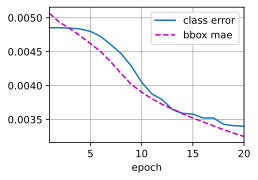

In [37]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    metric = d2l.Accumulator(4)
    net.train()
    for features, targets in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), targets.to(device)
        anchors, cls_preds, bbox_preds = net(X)
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks), bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

接下来我们开始预测我们的目标

In [43]:
X = torchvision.io.read_image('data2/banana-detection/bananas_val/images/1.png').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [44]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

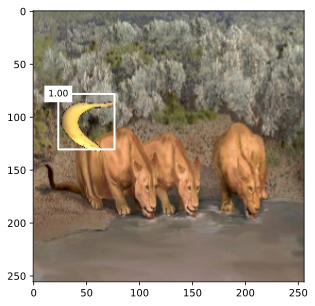

In [45]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)